In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import ufloat

plt.style.use(['science', 'notebook'])

import ROOT
import mplhep as hep

import boost_histogram as bh

plt.style.use(hep.style.ATLAS)

Welcome to JupyROOT 6.24/02


In [2]:
ROOT.gStyle.SetOptStat(0)
# ROOT.gROOT.SetStyle('BELLE2')
ROOT.gROOT.SetStyle('ATLAS')

# Monte Carlo: hands-on

## Decadimento a due componenti
Simulare il decadimento di una sostanza radioattiva con tempi di decadimento $\tau_1$ e $\tau_2$, con distribuzione di probabilità $$p(t) = \frac{f}{\tau_1} e^{-t/\tau_1} + \frac{1-f}{\tau_2} e^{-t/\tau_2}$$ con $\tau_1=0.1$ s e $\tau_2=1$ s, $f=0.3$ s.

In [3]:
from ROOT import TRandom3

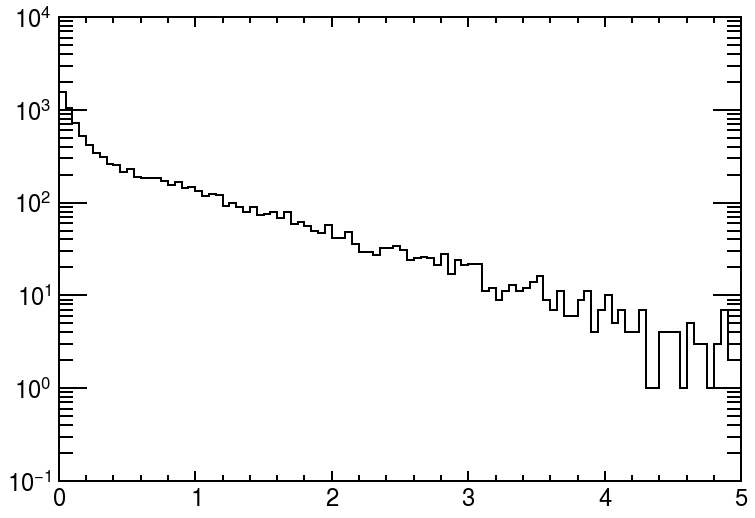

In [4]:
tau1 = 0.1
tau2 = 1.0
f = 0.3

rnd = TRandom3()
rnd.SetSeed(123456789)

from ROOT import TH1D

h = bh.Histogram(bh.axis.Regular(100,0.,5.))

ntot = 10000

t_arr = np.zeros(ntot)

for i in range(ntot):
    if rnd.Rndm()<f:
        t = -tau1*np.log(1-rnd.Rndm())
    else:
        t = -tau2*np.log(1-rnd.Rndm())
    h.fill(t)

hep.histplot(h, yerr=False, color='k')
plt.yscale('log')

Il tempo di decadimento viene misurato con un apparato caratterizzato da un'efficienza di rivelazione (dipendente dal tempo di decadimento) data $$\epsilon = \left(1-e^{-t/\tau_{acc}}
\right) $$ 

In altri termini ogni decadimento avvenuto ad un tempo t ha una probabilità di essere misurato pari a $\epsilon$ (con $\tau_{acc} = 0.01$ s) . Produrre un istogramma dei tempi misurati e sovrapporlo al primo.

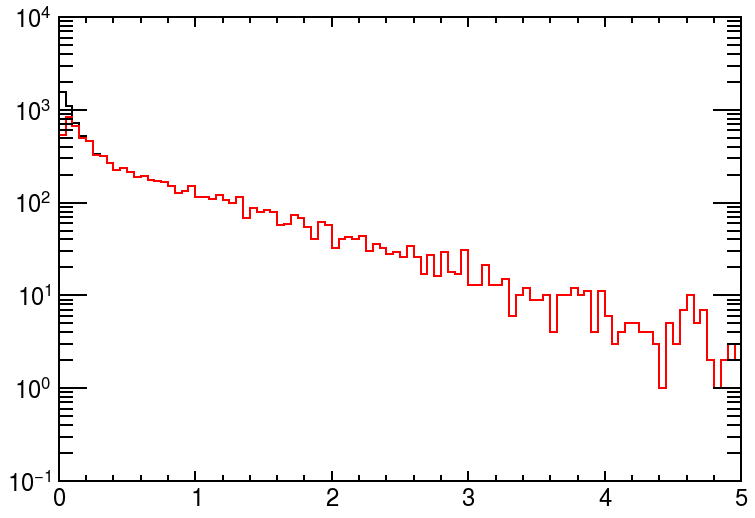

In [5]:
h = bh.Histogram(bh.axis.Regular(100,0.,5.))
h_eff = bh.Histogram(bh.axis.Regular(100,0.,5.))

tau_acc = 0.05

for i in range(ntot):
    if rnd.Rndm()<f:
        t = -tau1*np.log(1-rnd.Rndm())
    else:
        t = -tau2*np.log(1-rnd.Rndm())
    h.fill(t)
    if rnd.Rndm()<(1-np.exp(-t/tau_acc)):
        h_eff.fill(t)

hep.histplot(h, yerr=False, color='k')
hep.histplot(h_eff, yerr=False , color='r')
plt.yscale('log')

Il problema è che quello che misuriamo sarò anche frutto di una incertezza sul tempo, che quindi comporterà che il valore si disporrà attorno al valore vero con una certa distribuzione. 

Immaginiamo che l'errore sul tempo sia di $\delta_t = 0.1$. Rappresentiamo in un terzo histo i valori ricostruiti che prendano anche questa variabile in questo caso. 

Posso immaginare di ottenere $t_{reco}$ come una gaussiana centrata in $t$. 

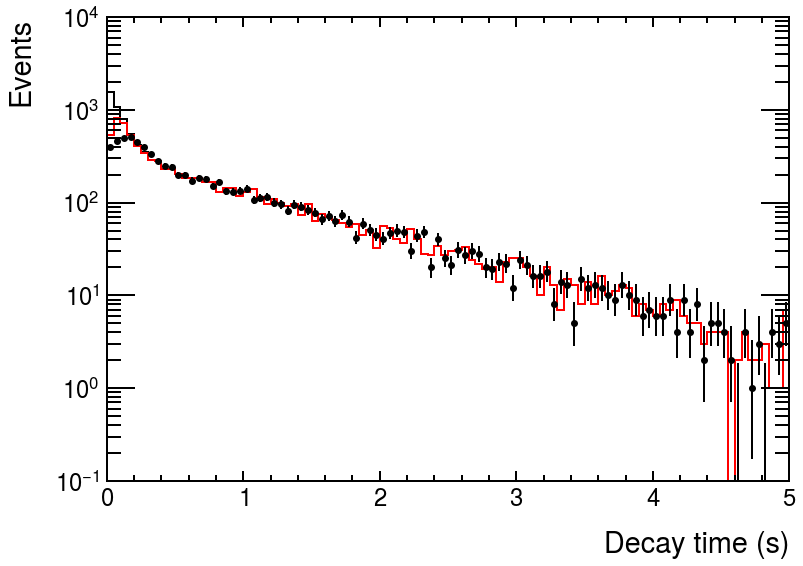

In [6]:
'''
h = TH1D("", "", 100, 0.0, 5.0)
h.SetTitle(';Time (s); Events')

h_eff = TH1D("", "", 100, 0.0, 5.0)
h_eff.SetLineColor(ROOT.kRed)
h_reco = TH1D("", "", 100, 0.0, 5.0)
h_reco.SetLineColor(ROOT.kBlack)
h_reco.SetMarkerSize(0.75)
'''

sigma = 0.1

h = bh.Histogram(bh.axis.Regular(100, 0., 5.))
h_eff = bh.Histogram(bh.axis.Regular(100, 0., 5.))
h_reco = bh.Histogram(bh.axis.Regular(100, 0., 5.))

for i in range(ntot):
    if rnd.Rndm()<f:
        t = -tau1*np.log(1-rnd.Rndm())
    else:
        t = -tau2*np.log(1-rnd.Rndm())
    # h.Fill(t)
    h.fill(t)
    if rnd.Rndm()<(1-np.exp(-t/tau_acc)):
        t_reco = t + rnd.Gaus(0, sigma)
        # h_eff.Fill(t)
        h_eff.fill(t)
        # h_reco.Fill(t_reco)
        h_reco.fill(t_reco)
        
'''
h.Draw()
h_eff.Draw('SAME')
h_reco.Draw('SAME E0')

ROOT.gROOT.GetListOfCanvases().Draw()
#ROOT.gPad.SetLogx()
ROOT.gPad.SetLogy()
ROOT.gROOT.GetListOfCanvases().Print('plot.pdf')
'''


hep.histplot(h, histtype='step', yerr=False, color='k')
hep.histplot(h_eff, histtype='step', yerr=False, color='r')
hep.histplot(h_reco, histtype='errorbar', color='k', markersize=5)
plt.yscale('log')
plt.ylabel('Events')
plt.xlabel('Decay time (s)')
plt.savefig('plot.pdf')

## Simulazione esperimento con sorgente radioattiva

Una sorgente luminosa puntiforme emette in maniera isotropa (cioè secondo con $p(\theta, \phi) = f(\theta, \phi)\sin\theta d\theta d\phi$ con $f(\theta, \phi)=1$). 

Calcolare il rapporto tra il numero di fotoni emessi e il numero di fotoni che incidono su un quadrato di lato $L = 1$ cm posto ad una distanza $d=20$ cm dalla sorgente

Passi da fare:
 1. Bisogna generare i fotoni che partono dalla sorgente: $d\Omega = \sin\theta d\theta d \phi = -d(\cos\theta) d\phi$. Estraggo il coseno tra -1 e 1 uniformemente.
 2. $\hat{r} = (\cos\phi\sin\theta, \sin\phi\sin\theta, \cos\theta)$, per cui avremo che il raggio $\vec{r} = \alpha\hat{r}$ andrà sul sensore quando avremo che il punto sarà sul sensore, ovvero la proiezione $d\cos(\theta)$ sarà nel quadrato. 

In [7]:
ntot = 1000000 # numero di fotoni generati

rnd = TRandom3(123456)

L = 0.01 ## Dimensione del sensore
d = 0.2

photo_n1 = 0
photo_n2 = 0

for i in range(0, ntot):
    ## 1. Genero fotoni
    phi = 2*np.pi*rnd.Rndm() ## phi in [0, 2π]
    costheta = 2*rnd.Rndm() - 1 ## cos(th) in [-1, 1]
    theta = np.arccos(costheta)
    
    if theta < np.pi/2: continue
    
    ## 2. Considero solo eventi sul sensore
    alpha = d/costheta
    x = alpha*np.cos(phi)*np.sin(theta)
    y = alpha*np.sin(phi)*np.sin(theta)
    
    if np.abs(x) < L/2 and np.abs(y) < L/2:
        photo_n1 = photo_n1 + 1 ## Sensore centrato
    if x < L and x > 0 and y < L and y > 0:
        photo_n2 = photo_n2 + 1 ## Sensore non centrato


In [8]:
p1 = photo_n1/ntot
p1 = ufloat(p1, np.sqrt(p1*(1-p1)/ntot))

print(f'Sensore centrato: {p1:.7u}, approx for L << d {L**2/(4*np.pi*d**2)}')

p2 = photo_n2/ntot
p2 = ufloat(p2, np.sqrt(p2*(1-p2)/ntot))
        
print(f'Sensore non-centrato: {p2:.7u}')

Sensore centrato: 0.00019300000+/-0.00001389110, approx for L << d 0.00019894367886486917
Sensore non-centrato: 0.00018800000+/-0.00001371002


Calcolare lo stesso rapporto nel caso in cui il quadrato non sia centrato sulla direzione radiale dalla (sorgente) ma la medesima passi per uno spigolo del quadrato 

## Calcolo del volume di un solido
Calcolare il volume del solido costituito da una sfera (R=1)  con "buco" cilindro coassiale ad essa e di raggio R/2. 

In [9]:
R = 1
R_c = R/2

rnd = TRandom3(123456789)

ntot = 10000000
n_acc = 0

for i in range(0, ntot):
    x = 2*R*rnd.Rndm()-R
    y = 2*R*rnd.Rndm()-R
    z = 2*R*rnd.Rndm()-R
    
    r2 = x**2 + y**2 + z**2
    if r2 < R**2:
        n_acc = n_acc + 1

p = n_acc/ntot
ep = np.sqrt(p*(1-p)/ntot)
p = ufloat(p, ep)

volume = p*(2*R)**3
print(f'{volume = }')

volume = 4.1879096+/-0.0012635145421493114


Volume nominale per la sfera è dato da $\frac{4}{3}\pi R^3$, ovvero

In [10]:
print(f'{4/3*np.pi*R**3 = }')

4/3*np.pi*R**3 = 4.1887902047863905


Il problema era quello di voler calcolare il volume della sfera meno quello del cilindro. Come possiamo fare? Controlliamo che sia nella sfera ma che sia fuori dal cilindro, quindi aggiungiamo una condizione successiva, che non stia nel cilindro

In [11]:
n_acc = 0

for i in range(0, ntot):
    x = 2*R*rnd.Rndm()-R
    y = 2*R*rnd.Rndm()-R
    z = 2*R*rnd.Rndm()-R
    
    r2 = x**2 + y**2 + z**2
    rxy2 = x**2 + y**2
    if r2 < R**2 and rxy2 > (R/2)**2:
        n_acc = n_acc + 1

p = n_acc/ntot
ep = np.sqrt(p*(1-p)/ntot)
p = ufloat(p, ep)

volume = p*(2*R)**3
print(f'{volume = }')

volume = 2.721612+/-0.0011985709875287321


## Approfondimento 1: Random Walk

In meccanica statistica, moltissimi fenomeni tra cui, per esempio, il processo di diffusione di un gas in un altro possono essere descritti da un processo _'random walk'_ cioè di passeggiata aleatoria. In un random walk unidimensionale, una particella c vincolata a muoversi lungo una linea retta nelle due direzioni (avanti e indietro). La particella si muove di moto rettilineo uniforme in una dimensione fino a quando non urta una particella del gas. 

La particella parte dall’origine dell’asse. Ad ogni movimento si sposta di una certa quantità $d$ a destra o a sinistra con la stessa probabilità. Si  consideri che d sia uniformemente distribuita tra  $-\sqrt{3}$ e $+\sqrt{3}$ (che corrisponde all'intervallo uniforme con deviazione standard 1 - verificare !)

Si simuli il moto della particella che parta dall'origine:
 1. si disegni il grafico dello spostamento quadratico medio dall'origine  per N=20, 40, 60 urti

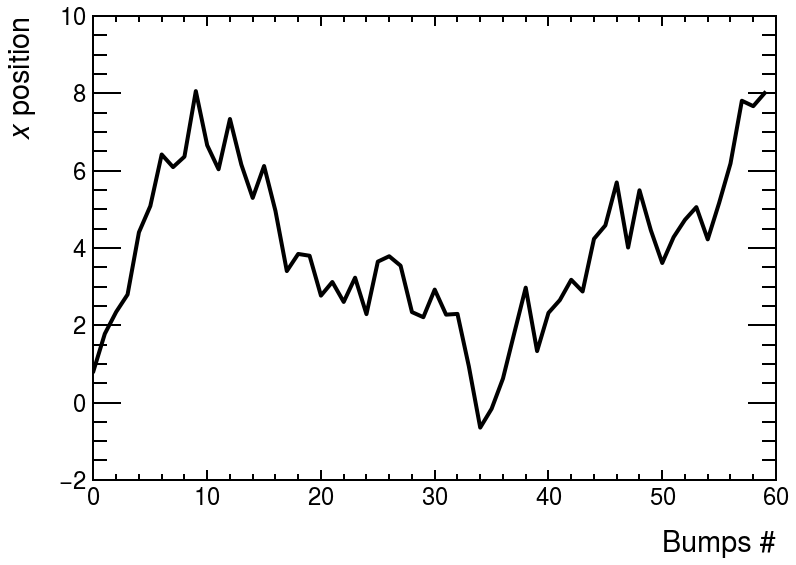

In [12]:
n_bump = 60

position = 0 ## Initial position
x_position_time = np.zeros(n_bump)

rnd = TRandom3(635462)

for i in range(n_bump):
    position += np.sqrt(3)*(2*rnd.Rndm() - 1)
    x_position_time[i] = position
    
plt.plot(x_position_time, color='k')
plt.xlabel('Bumps #')
plt.ylabel('$x$ position')
plt.show()

 2. si rappresenti in un istogramma la distribuzione della distanza dall’origine di n=1000 particelle dopo 100 step


Text(0, 1, 'Events')

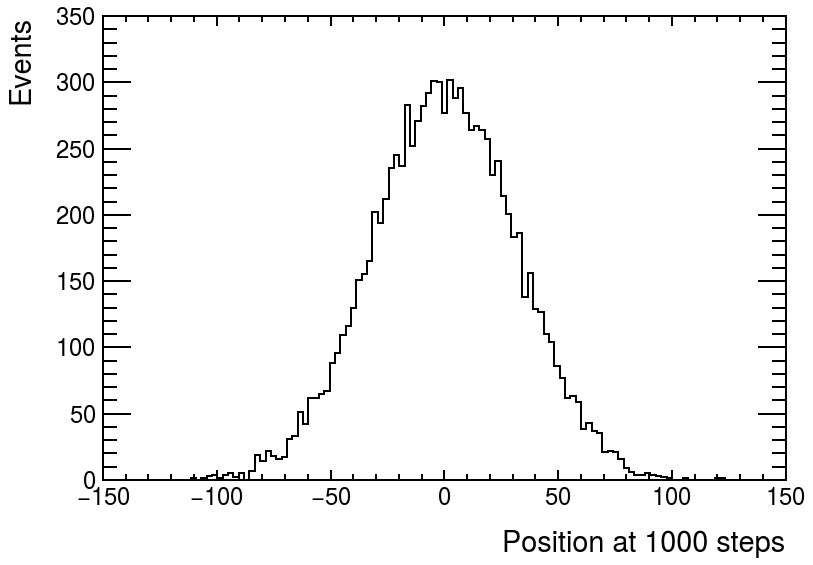

In [13]:
import time

n_particles = 10000
n_events = 1000

p_position = np.zeros(n_particles)

rnd.SetSeed(int(time.time()))

for i in range(n_particles):
    for j in range(n_events):
        p_position[i] += np.sqrt(3)*(2*rnd.Rndm() - 1)

plt.hist(p_position, bins=100, histtype='step', color='k')
plt.xlabel(f'Position at {n_events} steps')
plt.ylabel('Events')


### Random walking in 2 dimensioni
Utilizzo lo stesso metodo ma assegno una direzione lungo $x$ e una lungo $y$ secondo distribuzioni uniformi.  

In [14]:
n_particles = 10000
n_events = 500

p_position_x = np.zeros(n_particles)
p_position_y = np.zeros(n_particles)

rnd.SetSeed(int(time.time()))

for i in range(n_particles):
    for j in range(n_events):
        p_position_x[i] += np.sqrt(3)*(2*rnd.Rndm() - 1)
        p_position_y[i] += np.sqrt(3)*(2*rnd.Rndm() - 1)

Text(1, 0, 'Events')

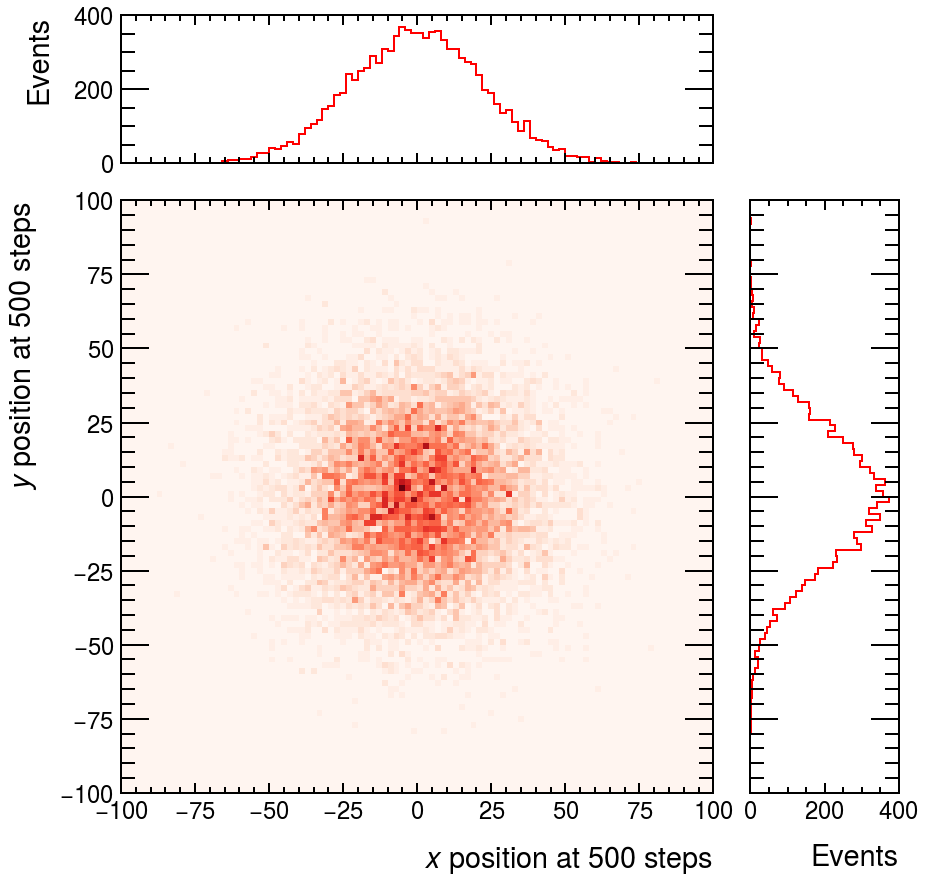

In [15]:
fig = plt.figure(figsize=(6,6))
grid = fig.add_gridspec(2,2, width_ratios=(4, 1), height_ratios=(1, 4), left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.1)

hxy = bh.Histogram(bh.axis.Regular(100, -100, 100),bh.axis.Regular(100, -100, 100))
hxy.fill(p_position_x,p_position_y)

ax = fig.add_subplot(grid[1,0])
hep.hist2dplot(hxy, ax=ax, cbar=False, cmap='Reds')

ax_x = fig.add_subplot(grid[0,0], sharex=ax)
ax_y = fig.add_subplot(grid[1,1], sharey=ax)

ax_x.tick_params(axis="x", labelbottom=False)
ax_y.tick_params(axis="y", labelleft=False)

hep.histplot(hxy.project(0), yerr=False, ax=ax_x, color='r')
hep.histplot(hxy.project(1), yerr=False, ax=ax_y, color='r', orientation='horizontal')

ax.set_xlabel(f'$x$ position at {n_events} steps')
ax.set_ylabel(f'$y$ position at {n_events} steps')
ax_x.set_ylabel('Events')
ax_y.set_xlabel('Events')

In [17]:
fig.savefig('rw_plot.pdf')

## Approfondimento 2: Momento di inerzia

Un corpo è costituito da una sfera di raggio R=6 cm con un buco sferico di raggio r=1 cm centrato in $\vec{r}_0 = (2,2,2)$ dal centro della sfera grande. Il corpo è costituito da un materiale con densità $\rho = 1.3 ~ g/cm^3$. 

 1. Si calcoli utilizzando il metodo MonteCarlo il momento di inerzia di una sfera completamente piena (senza il buco sferico) rispetto ad un asse che coincide con un suo diametro e lo si confronti con il valore noto 
 2. Si calcoli quindi il momento di inerzia del corpo (sfera con il buco) rispetto allo stesso asse precedente

Il momento di inerzia è definito come $$ I = \frac{\rho V}{N} \sum_{i=1}^N d_i^2,$$ dove $N$ è il numero di punti all'interno del corpo e $d_i$ la distanza dall'asse scelto. 